# ULMFit for Stance detection

# Imports and installs

In [10]:
import numpy as np
import pandas as pd
import keras
import string
import re
import nltk
import time
import tensorflow_hub as hub
import tensorflow as tf
import fastai
from fastai import *
from fastai.text import * 

from sklearn import metrics

from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split

# Read files
Only execute one of these

## Fake News Dataset

In [5]:
stances = pd.read_csv('data/stance/train_stances.csv')
bodies = pd.read_csv('data/stance/train_bodies.csv')

stances = stances.set_index(stances['Body ID']).drop('Body ID', axis = 1)
bodies = bodies.set_index(bodies['Body ID']).drop('Body ID', axis = 1)

data = stances.join(bodies)

data.rename(columns={"Headline": "text_a", "articleBody": "text_b", "Stance" : "stance"}, inplace=True)
data = data[['text_a', 'text_b', 'stance']]

data.text_b = data.text_b.map(lambda x : x.translate(str.maketrans('', '', string.punctuation)))
data.text_a = data.text_a.map(lambda x : x.translate(str.maketrans('', '', string.punctuation)))

data.text_a = data.text_a.str.lower()
data.text_b = data.text_b.str.lower()

data.text_a = data.text_a.str.strip(string.whitespace)
data.text_b = data.text_b.str.strip(string.whitespace)

df_train, df_test = train_test_split(data, test_size=0.33, random_state=42)

df_train = pd.get_dummies(df_train, columns=["stance"])
df_test = pd.get_dummies(df_test, columns=["stance"])

label_columns = ['stance_unrelated', 'stance_agree', 'stance_discuss', 'stance_disagree']

df_train.reset_index(inplace=True, drop = True)
df_test.reset_index(inplace=True, drop = True)


num_stances = 4

In [8]:
df_train

In [12]:
df_test.stance_unrelated.value_counts()

1    12015
0     4476
Name: stance_unrelated, dtype: int64

## SemEval

In [3]:
df_train = pd.read_csv('data/stance/trainingdata-all-annotations.txt', delimiter='\t', encoding='iso8859-2')
df_test = pd.read_csv('data/stance/testdata-taskA-all-annotations.txt', delimiter='\t'
                     ).append(pd.read_csv('data/stance/testdata-taskB-all-annotations.txt', delimiter='\t'))


df_train.drop(['ID', 'Opinion towards', 'Sentiment'], axis=1, inplace=True)
df_test.drop(['ID', 'Opinion towards', 'Sentiment'], axis = 1, inplace=True)

df_train.rename(columns={"Target": "text_a", "Tweet": "text_b", "Stance" : "stance"}, inplace=True)
df_test.rename(columns={"Target": "text_a", "Tweet": "text_b", "Stance" : "stance"}, inplace=True)

df_train.text_b = df_train.text_b.apply(lambda x:re.sub(r'http\S+', '', x))
df_test.text_b = df_test.text_b.apply(lambda x:re.sub(r'http\S+', '', x))

tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
df_train.text_b = df_train.text_b.apply(lambda x: tokenizer.tokenize(x))
df_test.text_b = df_test.text_b.apply(lambda x: tokenizer.tokenize(x))

df_train.text_b = df_train.text_b.apply(lambda x: ' '.join(x))
df_test.text_b = df_test.text_b.apply(lambda x: ' '.join(x))

df_train.text_b = df_train.text_b.map(lambda x : x.translate(str.maketrans('', '', string.punctuation)))
df_test.text_b = df_test.text_b.map(lambda x : x.translate(str.maketrans('', '', string.punctuation)))

df_train.text_a = df_train.text_a.str.lower()
df_train.text_b = df_train.text_b.str.lower()
df_test.text_a = df_test.text_a.str.lower()
df_test.text_b = df_test.text_b.str.lower()

df_train.text_b = df_train.text_b.str.strip(string.whitespace)
df_test.text_b = df_test.text_b.str.strip(string.whitespace)


df_train.reset_index(inplace=True, drop = True)
df_test.reset_index(inplace=True, drop = True)

df_train = pd.get_dummies(df_train, columns=["stance"])
df_test = pd.get_dummies(df_test, columns=["stance"])

label_columns = ['stance_AGAINST', 'stance_FAVOR', 'stance_NONE']

num_stances = 3

In [ ]:
df_train

# Training

## Language Model

In [9]:
data_lm = (TextList.from_df(df_train, ".", cols=['text_a', 'text_b'])
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=32))

data_lm.save('tmp_lm')

In [10]:
#Download pretrained model
learn = language_model_learner(data_lm, drop_mult=0.7, arch = AWD_LSTM, pretrained = True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


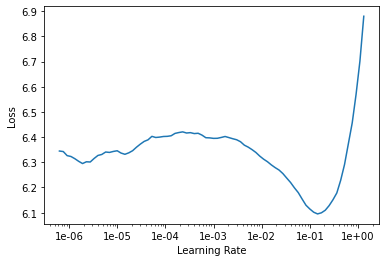

In [11]:
#Find best learning rate
%matplotlib inline
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [12]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.500412,1.784178,0.630885,07:48


In [13]:
learn.save('fit_head')

In [14]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (30133 items)
x: LMTextList
xxbos american bombing had signed my death certificate missing us journalist james wright foley goes unflinching to his death as isis behead him in horrific video as a warning to obama a schoolboy who was almost killed when he was knocked out by a massive electrical shock claims he now has superpowers like those of marvel ’s magneto 
 
  nikolai kryaglyachenko 12 from russia had been walking home from school when he lent briefly against a lamppost that was electrified from a faulty wire and was blasted across the pavement 
 
  “ when i came round i felt groggy but managed to get home and told my mum what had happened 
 
  “ when i woke up the next day and got out of bed i found some coins that had been lying on the mattress had stuck to my body ” he said 
 
  “ then when i was having breakfast and dropped my spoon it stuck to my chest ” 
 
  he said he was a keen fan of comics and believing that maybe h

In [15]:
learn.unfreeze()
learn.fit_one_cycle(30, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.820211,1.239200,0.740619,09:32
1,1.230154,0.699886,0.861408,09:33
2,0.780491,0.405034,0.923441,09:39
3,0.593737,0.284349,0.947228,09:40
4,0.593910,0.233235,0.957445,09:48
5,0.467475,0.200605,0.963752,09:37
6,0.388155,0.176465,0.968307,09:39
7,0.370260,0.156079,0.972406,09:46
8,0.349454,0.139368,0.975018,09:31
9,0.312503,0.125466,0.977534,09:32


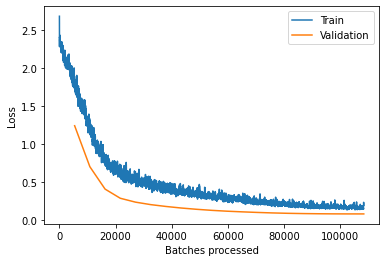

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('fine_tuned')
learn.save_encoder('ft_enc')

## Classifier

In [18]:
#data_lm = (TextList.from_df(df_train, "/content/drive/My Drive/Colab Notebooks/data/", cols='text')
                #.split_by_rand_pct(0.1)
                #.label_for_lm()
                #.databunch(bs=32))
data_clas = TextClasDataBunch.from_df(".", train_df=df_train, valid_df=df_test,
                                  vocab=data_lm.vocab, 
                                  text_cols=['text_a', 'text_b'], 
                                  label_cols=label_columns, 
                                  bs = 32)

In [19]:
data_clas.save('tmp_clas')

In [20]:
def precision(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()

In [21]:
def recall(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

In [22]:
learn = text_classifier_learner(data_clas, drop_mult=0.5, arch = AWD_LSTM)
learn.metrics = [accuracy_thresh, precision, recall]
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (33481 items)
x: TextList
xxbos american bombing had signed my death certificate missing us journalist james wright foley goes unflinching to his death as isis behead him in horrific video as a warning to obama a schoolboy who was almost killed when he was knocked out by a massive electrical shock claims he now has superpowers like those of marvel ’s magneto 
 
  nikolai kryaglyachenko 12 from russia had been walking home from school when he lent briefly against a lamppost that was electrified from a faulty wire and was blasted across the pavement 
 
  “ when i came round i felt groggy but managed to get home and told my mum what had happened 
 
  “ when i woke up the next day and got out of bed i found some coins that had been lying on the mattress had stuck to my body ” he said 
 
  “ then when i was having breakfast and dropped my spoon it stuck to my chest ” 
 
  he said he was a keen fan of comics and believing that maybe he had

In [23]:
learn.freeze()
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,precision,recall,time
0,0.292365,0.258326,0.897308,0.849306,0.707537,04:30


In [24]:
learn.save('first_factors')

In [25]:
learn.load('first_factors')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (33481 items)
x: TextList
xxbos american bombing had signed my death certificate missing us journalist james wright foley goes unflinching to his death as isis behead him in horrific video as a warning to obama a schoolboy who was almost killed when he was knocked out by a massive electrical shock claims he now has superpowers like those of marvel ’s magneto 
 
  nikolai kryaglyachenko 12 from russia had been walking home from school when he lent briefly against a lamppost that was electrified from a faulty wire and was blasted across the pavement 
 
  “ when i came round i felt groggy but managed to get home and told my mum what had happened 
 
  “ when i woke up the next day and got out of bed i found some coins that had been lying on the mattress had stuck to my body ” he said 
 
  “ then when i was having breakfast and dropped my spoon it stuck to my chest ” 
 
  he said he was a keen fan of comics and believing that maybe he had

In [26]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,precision,recall,time
0,0.251843,0.225465,0.917546,0.888242,0.764053,05:17
1,0.182328,0.134702,0.946456,0.933756,0.840822,05:48
2,0.148268,0.117227,0.955279,0.940122,0.873082,05:40
3,0.124594,0.077048,0.969756,0.968476,0.900370,05:24
4,0.111384,0.075358,0.971212,0.969527,0.908132,04:54


In [27]:
learn.save('second_factors')

In [28]:
learn.load('second_factors')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (33481 items)
x: TextList
xxbos american bombing had signed my death certificate missing us journalist james wright foley goes unflinching to his death as isis behead him in horrific video as a warning to obama a schoolboy who was almost killed when he was knocked out by a massive electrical shock claims he now has superpowers like those of marvel ’s magneto 
 
  nikolai kryaglyachenko 12 from russia had been walking home from school when he lent briefly against a lamppost that was electrified from a faulty wire and was blasted across the pavement 
 
  “ when i came round i felt groggy but managed to get home and told my mum what had happened 
 
  “ when i woke up the next day and got out of bed i found some coins that had been lying on the mattress had stuck to my body ” he said 
 
  “ then when i was having breakfast and dropped my spoon it stuck to my chest ” 
 
  he said he was a keen fan of comics and believing that maybe he had

In [29]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,precision,recall,time
0,0.098283,0.065799,0.974804,0.973205,0.918744,09:59
1,0.085741,0.059557,0.976715,0.970129,0.934570,09:03
2,0.080133,0.055558,0.978549,0.974321,0.934934,10:42
3,0.073978,0.052912,0.980080,0.976853,0.937360,10:03
4,0.078819,0.051732,0.980201,0.978504,0.938148,10:01


## Evaluation

In [30]:
# Predict on the test dataset
y_pred, y_true =  learn.get_preds()

In [31]:
metrics.f1_score(y_true, y_pred>0.35, average=None)

array([0.98661 , 0.808937, 0.938653, 0.594096])

In [32]:
metrics.accuracy_score(y_true, y_pred>0.35)

0.9450609423321812